# EEG-Based Emotion Recognition using EFDM and Machine Learning

## Project Overview

This notebook demonstrates a comprehensive EEG (Electroencephalography) based emotion recognition system using the DEAP dataset. The project transforms EEG signals into Enhanced Frequency Domain Maps (EFDM) and applies machine learning techniques to classify emotional states (positive vs negative valence).

## Key Features

- **DEAP Dataset Processing**: Load and preprocess EEG signals from multiple subjects
- **STFT Analysis**: Short-Time Fourier Transform for time-frequency decomposition
- **EFDM Generation**: Enhanced Frequency Domain Mapping for spatial-spectral representation
- **HOG Feature Extraction**: Histogram of Oriented Gradients from EFDM images
- **Dimensionality Reduction**: PCA and StandardScaler for feature optimization
- **Multiple ML Models**: Random Forest, Extra Trees, and LightGBM classifiers
- **Comprehensive Evaluation**: Cross-validation, confusion matrices, and ROC analysis

## Dataset Information

- **Source**: DEAP Dataset (Database for Emotion Analysis using Physiological Signals)
- **[Dataset Link](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html)**
- **Channels**: 32 EEG electrodes
- **Sampling Rate**: 128 Hz
- **Labels**: Valence (positive/negative emotion) based on self-assessment ratings
- **Trials**: Multiple video-watching sessions per subject

## Methodology

1. **Data Loading**: Load preprocessed DEAP EEG data files
2. **Signal Processing**: Apply STFT to extract time-frequency information
3. **EFDM Creation**: Map electrode positions to spatial grid with frequency content
4. **Feature Engineering**: Extract HOG features from EFDM representations
5. **Data Preprocessing**: Apply SMOTE, scaling, and PCA
6. **Model Training**: Train and tune multiple machine learning models
7. **Evaluation**: Comprehensive performance assessment and visualization

## Technical Stack

- **Signal Processing**: SciPy, NumPy
- **Image Processing**: OpenCV, scikit-image (HOG)
- **Machine Learning**: Scikit-learn, LightGBM
- **Data Handling**: Pandas, Pickle
- **Visualization**: Matplotlib, Seaborn
- **Imbalanced Learning**: imbalanced-learn (SMOTE)

## 1. Import Required Libraries

Import all necessary libraries for EEG signal processing, machine learning, and data visualization.

In [1]:
# Core Libraries
import pickle
import numpy as np
import pandas as pd
import os
from collections import Counter

# Signal Processing
from scipy.signal import stft

# Image Processing and Computer Vision
import cv2
from skimage.feature import hog

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           roc_curve, auc, f1_score, precision_score, recall_score)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Imbalanced Learning
from imblearn.over_sampling import BorderlineSMOTE

# Additional ML Libraries
import lightgbm as lgb
import joblib

print("All libraries imported successfully!")

# Load sample DEAP dataset file
sample_file_path = r"D:\4th Biomedical\Depression-GP-2025\Deap dataset\EEG SIGNALS\data_preprocessed_python\s09.dat"

try:
    with open(sample_file_path, "rb") as file:
        data = pickle.load(file, encoding="latin-1")
    
    # Extract EEG signals
    eeg_signals = data['data'][:, :, :] 
    
    print("=== DEAP Dataset Structure ===")
    print(f"EEG Data Shape: {eeg_signals.shape}")
    print(f"Format: (trials, channels, samples)")
    print(f"Number of trials: {eeg_signals.shape[0]}")
    print(f"Number of EEG channels: {eeg_signals.shape[1]}")
    print(f"Samples per trial: {eeg_signals.shape[2]}")
    print(f"Duration per trial: {eeg_signals.shape[2]/128:.1f} seconds (at 128Hz)")
    
    # Check if labels exist
    if 'labels' in data:
        labels = data['labels']
        print(f"Labels shape: {labels.shape}")
        print(f"Label columns: [valence, arousal, dominance, liking]")
    
except FileNotFoundError:
    print("Sample file not found. Please update the file path.")
    eeg_signals = None


All libraries imported successfully!
=== DEAP Dataset Structure ===
EEG Data Shape: (40, 40, 8064)
Format: (trials, channels, samples)
Number of trials: 40
Number of EEG channels: 40
Samples per trial: 8064
Duration per trial: 63.0 seconds (at 128Hz)
Labels shape: (40, 4)
Label columns: [valence, arousal, dominance, liking]
=== DEAP Dataset Structure ===
EEG Data Shape: (40, 40, 8064)
Format: (trials, channels, samples)
Number of trials: 40
Number of EEG channels: 40
Samples per trial: 8064
Duration per trial: 63.0 seconds (at 128Hz)
Labels shape: (40, 4)
Label columns: [valence, arousal, dominance, liking]


## 2. Data Loading and Initial Exploration

### 2.1 Load Sample DEAP Dataset

Load a sample subject's EEG data to understand the data structure and perform initial exploration.

In [2]:
# Define the main directory containing DEAP dataset files
# Update this path to match your DEAP dataset location
org = r"D:\4th Biomedical\Depression-GP-2025\Deap dataset\EEG SIGNALS\data_preprocessed_python"

print(f"Dataset directory: {org}")
if os.path.exists(org):
    files = os.listdir(org)
    print(f"Number of subject files: {len(files)}")
    print(f"Sample files: {files[:5]}...")
else:
    print("Directory not found. Please update the path.")


Dataset directory: D:\4th Biomedical\Depression-GP-2025\Deap dataset\EEG SIGNALS\data_preprocessed_python
Number of subject files: 32
Sample files: ['s01.dat', 's02.dat', 's03.dat', 's04.dat', 's05.dat']...


## 3. Signal Processing and Feature Extraction

### 3.1 Short-Time Fourier Transform (STFT)

Implement STFT to analyze the time-frequency characteristics of EEG signals.

In [3]:
from scipy.signal import stft

def compute_stft(signal, fs=128, nperseg=128):
    """
    Compute Short-Time Fourier Transform (STFT) of a single EEG channel.
    
    Parameters:
    -----------
    signal : array-like
        1D array of EEG samples from a single channel
    fs : int, default=128
        Sampling frequency in Hz (DEAP dataset uses 128 Hz)
    nperseg : int, default=128
        Length of each segment for STFT (window size)
        Default corresponds to 1 second of data at 128 Hz
    
    Returns:
    --------
    numpy.ndarray
        Time-frequency magnitude spectrogram
        Shape: (frequency_bins, time_bins)
    """
    # Compute STFT
    f, t, Zxx = stft(signal, fs=fs, nperseg=nperseg)
    
    # Return magnitude of complex STFT coefficients
    return np.abs(Zxx)

# Demonstrate STFT on sample data
if eeg_signals is not None:
    # Apply STFT to first trial, second channel
    sample_stft = compute_stft(eeg_signals[0, 1, :])
    
    print("=== STFT Analysis Results ===")
    print(f"STFT Shape: {sample_stft.shape}")
    print(f"Frequency bins: {sample_stft.shape[0]}")
    print(f"Time bins: {sample_stft.shape[1]}")
    print(f"Frequency resolution: {128/128:.1f} Hz per bin")
    print(f"Time resolution: {128/128:.1f} seconds per bin")
    
    # Display sample values
    print(f"Sample STFT values (first 5x5):")
    print(sample_stft[:5, :5])
else:
    print("No EEG data available for STFT demonstration")

=== STFT Analysis Results ===
STFT Shape: (65, 127)
Frequency bins: 65
Time bins: 127
Frequency resolution: 1.0 Hz per bin
Time resolution: 1.0 seconds per bin
Sample STFT values (first 5x5):
[[1.03040050e-01 4.15834851e-03 7.74663737e-04 6.39162486e-03
  1.49252077e-02]
 [1.06306850e-01 1.66413047e-02 1.14743672e-02 2.24849052e-02
  1.22747020e-02]
 [3.50938333e-01 3.96905686e-02 3.38013312e-02 8.67942347e-02
  5.04142625e-02]
 [1.02832669e+00 1.47181359e+00 1.51564711e+00 1.90775249e+00
  1.80864016e+00]
 [1.93741628e+00 3.06550946e+00 3.54362506e+00 4.18829092e+00
  5.73325936e+00]]


In [4]:
# Aggregate STFT across all 32 EEG channels for a single trial
# This creates a combined time-frequency representation

if eeg_signals is not None:
    # Initialize aggregated STFT matrix
    x = np.zeros(sample_stft.shape)
    trial_index = 4  # Use 5th trial (index 4)
    
    print(f"Aggregating STFT across all 32 channels for trial {trial_index}...")
    
    # Sum STFT magnitudes across all channels
    for channel in range(32):
        channel_stft = compute_stft(eeg_signals[trial_index, channel, :])
        x += channel_stft
    
    print(f"Aggregated STFT shape: {x.shape}")
    print(f"Min value: {np.min(x):.2f}")
    print(f"Max value: {np.max(x):.2f}")
    print(f"Mean value: {np.mean(x):.2f}")
else:
    print("No EEG data available for multi-channel STFT")

Aggregating STFT across all 32 channels for trial 4...
Aggregated STFT shape: (65, 127)
Min value: 0.00
Max value: 1842.21
Mean value: 37.76


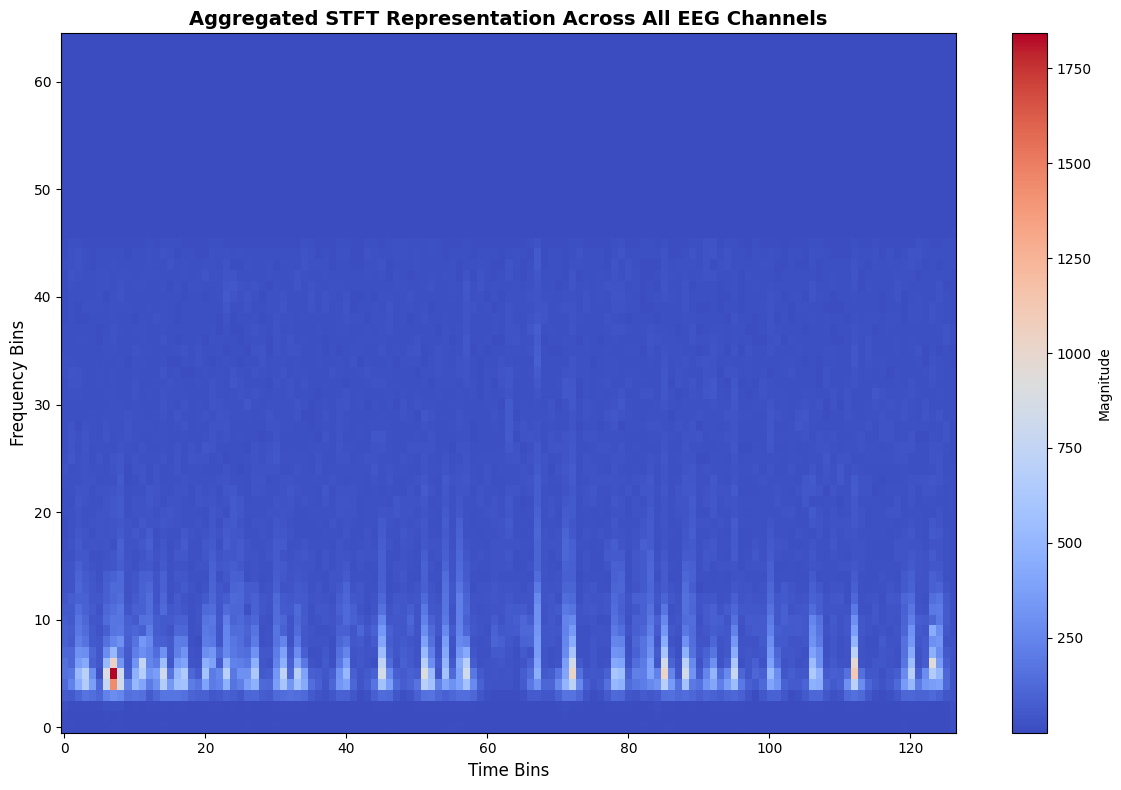

This representation shows the combined time-frequency activity across all EEG channels.


In [5]:
# Visualize the aggregated STFT as a time-frequency representation
if 'x' in locals():
    plt.figure(figsize=(12, 8))
    plt.imshow(x, cmap='coolwarm', aspect='auto', origin='lower')
    plt.colorbar(label='Magnitude')
    plt.title('Aggregated STFT Representation Across All EEG Channels', fontsize=14, fontweight='bold')
    plt.xlabel('Time Bins', fontsize=12)
    plt.ylabel('Frequency Bins', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("This representation shows the combined time-frequency activity across all EEG channels.")
else:
    print("No aggregated STFT data available for visualization")

### 3.2 Enhanced Frequency Domain Mapping (EFDM)

Create spatial-spectral representations by mapping EEG electrode positions to a 2D grid with frequency information.

In [6]:
# electrode_positions = {
#     "Fp1": (0, 1), "Fp2": (0, 3),
#     "F7": (1, 0), "F3": (1, 1), "Fz": (1, 2), "F4": (1, 3), "F8": (1, 4),
#     "T3": (2, 0), "C3": (2, 1), "Cz": (2, 2), "C4": (2, 3), "T4": (2, 4),
#     "T5": (3, 0), "P3": (3, 1), "Pz": (3, 2), "P4": (3, 3), "T6": (3, 4),
#     "O1": (4, 1), "O2": (4, 3)
# }


In [7]:
# Define electrode positions for spatial mapping
# Map 32 EEG channels to a 4x8 grid for EFDM representation
electrode_positions = {f'ch{i}': (x, y) for i, (x, y) in enumerate((x, y) for x in range(4) for y in range(8))}

print("=== Electrode Positioning for EFDM ===")
print(f"Total channels: {len(electrode_positions)}")
print(f"Grid dimensions: 4 rows × 8 columns")
print("Sample electrode positions:")
for i, (channel, pos) in enumerate(list(electrode_positions.items())[:8]):
    print(f"  {channel}: row {pos[0]}, col {pos[1]}")
    
print(f"This creates a spatial representation maintaining electrode relationships.")

=== Electrode Positioning for EFDM ===
Total channels: 32
Grid dimensions: 4 rows × 8 columns
Sample electrode positions:
  ch0: row 0, col 0
  ch1: row 0, col 1
  ch2: row 0, col 2
  ch3: row 0, col 3
  ch4: row 0, col 4
  ch5: row 0, col 5
  ch6: row 0, col 6
  ch7: row 0, col 7
This creates a spatial representation maintaining electrode relationships.


Creating EFDM with dimensions: 4×8×65

=== EFDM Generation Results ===
EFDM Shape: (4, 8, 65)
Spatial dimensions: 4×8
Frequency bins: 65


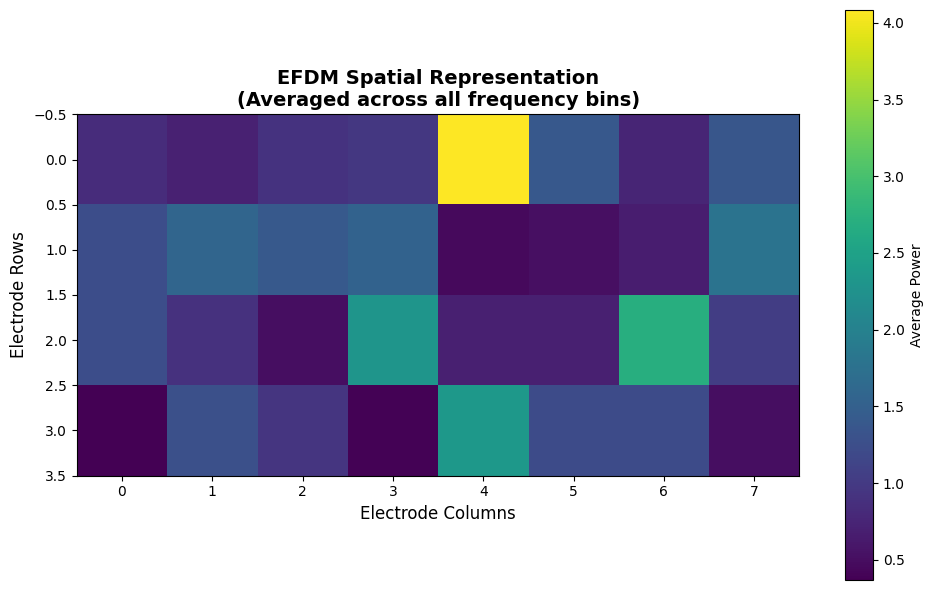

Min power: 0.368
Max power: 4.083
Mean power: 1.206


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def create_efdm(eeg_trial):
    """
    Generate Enhanced Frequency Domain Map (EFDM) for a single EEG trial.
    
    This function creates a spatial-spectral representation by:
    1. Computing STFT for each EEG channel
    2. Extracting frequency distribution (averaged across time)
    3. Mapping each channel to its spatial position on a 4x8 grid
    4. Creating a 3D representation: (rows, cols, frequency_bins)
    
    Parameters:
    -----------
    eeg_trial : numpy.ndarray
        EEG data for one trial with shape (channels, samples)
        
    Returns:
    --------
    numpy.ndarray
        EFDM representation with shape (4, 8, frequency_bins)
    """
    # Get dimensions from sample STFT
    sample_stft = compute_stft(eeg_trial[0])
    freq_bins, time_bins = sample_stft.shape
    
    # Initialize EFDM with spatial dimensions (4x8) and frequency dimension
    efdm = np.zeros((4, 8, freq_bins))
    
    print(f"Creating EFDM with dimensions: 4×8×{freq_bins}")
    
    # Process each electrode
    for i, (electrode, pos) in enumerate(electrode_positions.items()):
        if i < eeg_trial.shape[0]:  # Ensure we don't exceed available channels
            # Compute STFT for current channel
            stft_result = compute_stft(eeg_trial[i])
            
            # Average power across time bins to get frequency distribution
            avg_power = np.mean(stft_result, axis=1)
            
            # Assign frequency distribution to spatial position
            efdm[pos[0], pos[1], :] = avg_power
    
    return efdm

# Demonstrate EFDM creation
if eeg_signals is not None:
    # Generate EFDM for first trial
    efdm_img = create_efdm(eeg_signals[1, :, :])
    
    print(f"\n=== EFDM Generation Results ===")
    print(f"EFDM Shape: {efdm_img.shape}")
    print(f"Spatial dimensions: {efdm_img.shape[0]}×{efdm_img.shape[1]}")
    print(f"Frequency bins: {efdm_img.shape[2]}")
    
    # Visualize the EFDM (averaged across frequency dimension)
    plt.figure(figsize=(10, 6))
    efdm_2d = np.mean(efdm_img, axis=-1)
    plt.imshow(efdm_2d, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Average Power')
    plt.title('EFDM Spatial Representation\n(Averaged across all frequency bins)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Electrode Columns', fontsize=12)
    plt.ylabel('Electrode Rows', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print(f"Min power: {np.min(efdm_2d):.3f}")
    print(f"Max power: {np.max(efdm_2d):.3f}")
    print(f"Mean power: {np.mean(efdm_2d):.3f}")
else:
    print("No EEG data available for EFDM demonstration")


=== EFDM Image Preprocessing ===
Original EFDM 2D shape: (4, 8)
Resized image shape: (64, 64)
Pixel value range: [0.000, 1.000]


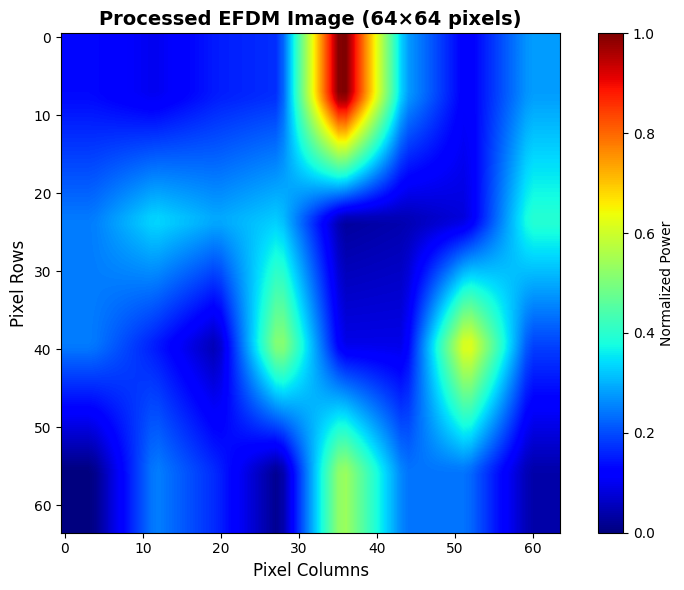

This standardized format is ready for HOG feature extraction.


In [9]:
import cv2

# Convert EFDM to standardized image format for feature extraction
if 'efdm_img' in locals():
    # Average across frequency dimension to create 2D spatial representation
    efdm_2d = np.mean(efdm_img, axis=-1)
    
    # Resize to standard image dimensions (64x64 pixels)
    efdm_resized = cv2.resize(efdm_2d, (64, 64))
    
    # Normalize pixel values to [0, 1] range
    efdm_min, efdm_max = np.min(efdm_resized), np.max(efdm_resized)
    efdm_resized = (efdm_resized - efdm_min) / (efdm_max - efdm_min)
    
    print("=== EFDM Image Preprocessing ===")
    print(f"Original EFDM 2D shape: {efdm_2d.shape}")
    print(f"Resized image shape: {efdm_resized.shape}")
    print(f"Pixel value range: [{np.min(efdm_resized):.3f}, {np.max(efdm_resized):.3f}]")
    
    # Visualize the processed EFDM image
    plt.figure(figsize=(8, 6))
    plt.imshow(efdm_resized, cmap='jet', interpolation='bilinear')
    plt.colorbar(label='Normalized Power')
    plt.title('Processed EFDM Image (64×64 pixels)', fontsize=14, fontweight='bold')
    plt.xlabel('Pixel Columns', fontsize=12)
    plt.ylabel('Pixel Rows', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("This standardized format is ready for HOG feature extraction.")
else:
    print("No EFDM data available for image preprocessing")


## 4. Feature Extraction and Dataset Preparation

### 4.1 Utility Functions

Define helper functions for data shuffling and comprehensive feature extraction.

In [10]:
def shuffle_data(x, y):
    """
    Randomly shuffle the dataset while maintaining correspondence between features and labels.
    
    Parameters:
    -----------
    x : numpy.ndarray
        Feature matrix
    y : numpy.ndarray
        Label vector
        
    Returns:
    --------
    tuple
        (shuffled_features, shuffled_labels)
    """
    # Generate random permutation of indices
    indices = np.random.permutation(len(x))
    
    # Apply the shuffle to both features and labels
    x_shuffled = x[indices]
    y_shuffled = y[indices]
    
    return x_shuffled, y_shuffled

print("Data shuffling function defined successfully.")

Data shuffling function defined successfully.


### 4.2 Comprehensive EEG Feature Extraction

Extract HOG features from EFDM representations for all subjects and trials in the dataset.

In [11]:
def Extract_EEG_Features3(dataframe):
    """
    Extract HOG features from EFDM representations for emotion recognition.
    
    This function processes multiple DEAP dataset files and extracts features using:
    1. EFDM generation from EEG signals
    2. Image resizing and normalization
    3. HOG (Histogram of Oriented Gradients) feature extraction
    4. Valence-based emotion labeling
    
    Parameters:
    -----------
    dataframe : pandas.DataFrame
        DataFrame containing file paths to DEAP dataset files
        
    Returns:
    --------
    tuple
        (features, labels) where features are HOG descriptors and labels are emotion categories
    """
    features, labels = list(), list()
    
    print(f"Processing {len(dataframe)} DEAP dataset files...")
    
    for i, path in enumerate(dataframe.iloc[:, 0]):
        try:
            # Load DEAP dataset file
            with open(path, "rb") as file:
                data = pickle.load(file, encoding="latin-1")
                
            eeg_signals = data['data']
            valence = data['labels'][:, 0]  # Extract valence ratings (1-9 scale)
            
            print(f"Processing file {i+1}/{len(dataframe)}: {os.path.basename(path)}")
            print(f"  Trials: {eeg_signals.shape[0]}, Channels: {eeg_signals.shape[1]}")
            
            # Process each trial (video) in the dataset
            for video in range(eeg_signals.shape[0]):
                # Use signal starting from 3 seconds (3*128 samples) to skip initial artifacts
                trial_signal = eeg_signals[video, :, 3*128:]
                
                # Generate EFDM representation
                efdm = create_efdm(trial_signal)
                
                # Convert to 2D image and resize to standard dimensions
                efdm_2d = np.mean(efdm, axis=-1)
                efdm_resized = cv2.resize(efdm_2d, (64, 64))
                
                # Normalize the image
                efdm_norm = (efdm_resized - np.min(efdm_resized)) / (np.max(efdm_resized) - np.min(efdm_resized))
                
                # Extract HOG features
                hog_features = hog(
                    efdm_norm,
                    orientations=9,          # Number of gradient orientations
                    pixels_per_cell=(8, 8),  # Size of each cell (8x8 pixels)
                    cells_per_block=(2, 2),  # Blocks for normalization (2x2 cells)
                    block_norm='L2-Hys',     # Normalization method
                    transform_sqrt=True      # Apply power law compression
                )
                
                features.append(hog_features)
                
                # Label based on valence: >4 = positive, ≤4 = negative
                emotion_label = 'positive' if valence[video] > 4 else 'Negative'
                labels.append(emotion_label)
                
            print(f"  Extracted features from {eeg_signals.shape[0]} trials")
            
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue
    
    # Convert to numpy arrays and shuffle
    features = np.array(features)
    labels = np.array(labels)
    
    print(f"\n=== Feature Extraction Summary ===")
    print(f"Total samples extracted: {len(features)}")
    print(f"HOG feature dimension: {features.shape[1] if len(features) > 0 else 'N/A'}")
    print(f"Class distribution: {Counter(labels)}")
    
    # Shuffle the dataset
    features, labels = shuffle_data(features, labels)
    print("Dataset shuffled successfully.")
    
    return features, labels

### 4.3 Dataset Preparation and File Management

Prepare the complete dataset by listing all DEAP files and creating train-test splits.

In [13]:
import os

# Define the organization directory (org)
org = r"D:\4th Biomedical\Depression-GP-2025\Deap dataset\EEG SIGNALS\data_preprocessed_python"  # <-- Update this line with the correct path

# Create list of all DEAP dataset files
data_list = [os.path.join(org, i) for i in os.listdir(org) if i.endswith('.dat')]

# Documentation printout
print(f"=== DEAP Dataset Files ===")
print(f"Total subject files found: {len(data_list)}")
print(f"File format: .dat (pickle files)")
print(f"Sample files:")

=== DEAP Dataset Files ===
Total subject files found: 32
File format: .dat (pickle files)
Sample files:


In [14]:
import pandas as pd

# Create DataFrame for easier data management
dataframe = pd.DataFrame(data_list, columns=['file_path'])
print(f"Created DataFrame with {len(dataframe)} file paths")

Created DataFrame with 32 file paths


In [15]:
# Preview the dataset file structure
dataframe.head()

,file_path
0,D:\4th Biomedical\Depression-GP-2025\Deap data...
1,D:\4th Biomedical\Depression-GP-2025\Deap data...
2,D:\4th Biomedical\Depression-GP-2025\Deap data...
3,D:\4th Biomedical\Depression-GP-2025\Deap data...
4,D:\4th Biomedical\Depression-GP-2025\Deap data...


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Split dataset into training and testing sets (80-20 split)
# This ensures different subjects are in train and test sets
train, test = train_test_split(dataframe, random_state=42, test_size=0.2)

print(f"=== Dataset Split ===")
print(f"Training files: {len(train)} subjects")
print(f"Testing files: {len(test)} subjects")
print(f"Train-test ratio: {len(train)}/{len(test)} = {len(train)/len(test):.1f}:1")

=== Dataset Split ===
Training files: 25 subjects
Testing files: 7 subjects
Train-test ratio: 25/7 = 3.6:1


## 5. Training Data Extraction and Analysis

### 5.1 Extract Features from Training Set

Process training files to extract HOG features from EFDM representations.

In [18]:
# Extract features from training dataset
print("Starting feature extraction from training files...")
print("This process may take several minutes depending on dataset size...")
x_train, y_train = Extract_EEG_Features3(train)

Starting feature extraction from training files...
This process may take several minutes depending on dataset size...
Processing 25 DEAP dataset files...
Processing file 1/25: s26.dat
  Trials: 40, Channels: 40
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Processing file 1/25: s26.dat
  Trials: 40, Channels: 40
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating E

### 5.2 Training Data Analysis and Visualization

Analyze the class distribution in the extracted training features and visualize the data characteristics.

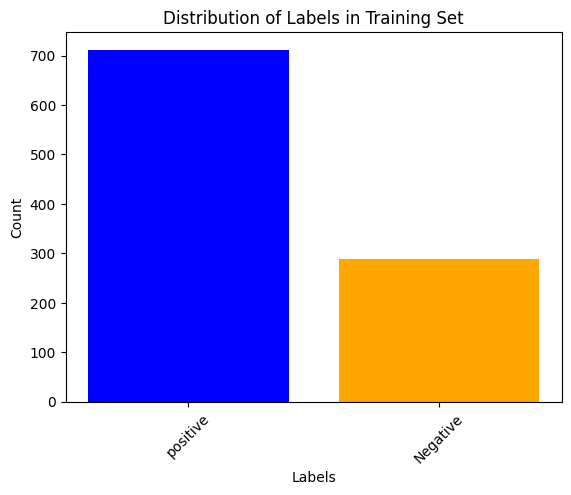

Counter({'positive': 712, 'Negative': 288})


In [19]:
from collections import Counter
count = Counter(y_train)

print("=== Training Data Class Distribution ===")
print(f"Class counts: {dict(count)}")
print(f"Total training samples: {sum(count.values())}")

# Calculate class imbalance ratio
classes = list(count.keys())
if len(classes) == 2:
    ratio = max(count.values()) / min(count.values())
    print(f"Class imbalance ratio: {ratio:.2f}:1")

# Visualize class distribution
plt.figure(figsize=(10, 6))
colors = ['skyblue', 'lightcoral']
bars = plt.bar(count.keys(), count.values(), color=colors, alpha=0.8, edgecolor='black')
plt.title("Distribution of Emotion Labels in Training Set", fontsize=14, fontweight='bold')
plt.xlabel("Emotion Labels", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, count.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(count.values())*0.01, 
             str(value), ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 5.3 Class Imbalance Handling with SMOTE

Apply Borderline SMOTE to balance the training dataset and improve model performance on minority classes.

In [20]:
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

# Apply Borderline SMOTE to balance training data
print("Applying Borderline SMOTE for class balancing...")
print("Original training distribution:", Counter(y_train))

# Initialize Borderline SMOTE
BL = BorderlineSMOTE(random_state=42)
x_train, y_train = BL.fit_resample(x_train, y_train)

# Shuffle the resampled data
x_train, y_train = shuffle_data(x_train, y_train)

print("After SMOTE distribution:", Counter(y_train))
print(f"Training set size: {len(x_train)} samples")
print("Class balancing completed successfully!")

c:\Users\vip\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### 5.4 Test Data Extraction and Preparation

Extract features from test files and prepare the complete dataset for machine learning.

In [21]:
# Extract features from test dataset
print("Starting feature extraction from test files...")
print("Processing test subjects for evaluation...")
x_test, y_test = Extract_EEG_Features3(test)

Processing 7 DEAP dataset files...
Processing file 1/7: s30.dat
  Trials: 40, Channels: 40
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Processing file 1/7: s30.dat
  Trials: 40, Channels: 40
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM with dimensions: 4×8×65
Creating EFDM wit

In [22]:
# Apply SMOTE to test data and shuffle
print("Applying SMOTE to test data...")
print("Original test distribution:", Counter(y_test))

x_test, y_test = BL.fit_resample(x_test, y_test)
x_test, y_test = shuffle_data(x_test, y_test)

print("After SMOTE test distribution:", Counter(y_test))
print(f"Test set size: {len(x_test)} samples")

c:\Users\vip\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [23]:
# Verify training data shape
print(f"Training features shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"HOG feature dimension: {x_train.shape[1]}")
x_train.shape

(1424, 1764)

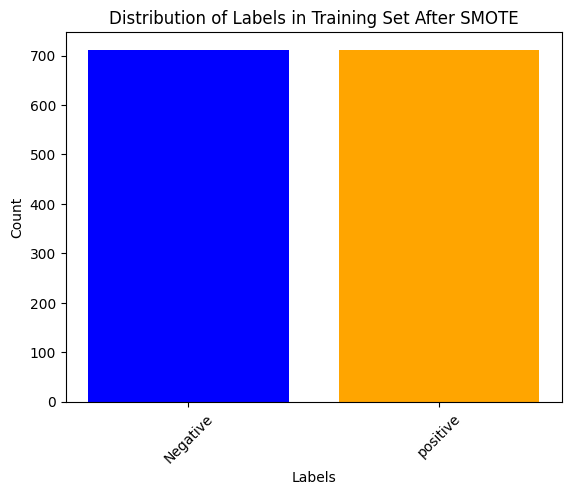

In [24]:
count = Counter(y_train)

plt.figure(figsize=(10, 6))
colors = ['lightgreen', 'lightcoral']
bars = plt.bar(count.keys(), count.values(), color=colors, alpha=0.8, edgecolor='black')
plt.title("Distribution of Emotion Labels After SMOTE Balancing", fontsize=14, fontweight='bold')
plt.xlabel("Emotion Labels", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, count.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(count.values())*0.01, 
             str(value), ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Balanced training set: {dict(count)}")
print(f"Total samples: {sum(count.values())}")

## 6. Data Preprocessing and Dimensionality Reduction

### 6.1 Label Encoding

Convert string labels to numerical format for machine learning algorithms.

In [25]:
# Define emotion label mapping for binary classification
map_dic = {'positive': 0, 'Negative': 1}

print("=== Label Encoding ===")
print("Emotion to numeric mapping:")
for emotion, code in map_dic.items():
    print(f"  {emotion} -> {code}")

print(f"\nThis creates a binary classification problem:")

In [26]:
# Convert string labels to numerical labels
y_train = np.array([map_dic[i] for i in y_train])
y_test = np.array([map_dic[i] for i in y_test])

print("Label conversion completed:")
print(f"Training labels: {len(y_train)} samples")
print(f"Test labels: {len(y_test)} samples")
print(f"Training label distribution: {Counter(y_train)}")
print(f"Test label distribution: {Counter(y_test)}")

### 6.2 Feature Scaling and Principal Component Analysis

Apply standardization and dimensionality reduction to optimize the feature space for machine learning.

In [27]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler , MinMaxScaler
# Define the model


In [28]:
# Initialize preprocessing components
print("=== Preprocessing Setup ===")

# StandardScaler for feature normalization
ss = StandardScaler()
print("StandardScaler initialized for feature normalization")

# PCA for dimensionality reduction
pca = PCA(n_components=200)
print(f"PCA initialized with {pca.n_components} components")

print(f"Original feature dimension: {x_train.shape[1]}")
print(f"Target reduced dimension: {pca.n_components}")

In [29]:
# Apply StandardScaler and PCA transformation
print("=== Feature Preprocessing Pipeline ===")

# Step 1: Standardize features
print("1. Applying StandardScaler...")
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)
print(f"   Training features standardized: {x_train_scaled.shape}")
print(f"   Test features standardized: {x_test_scaled.shape}")

# Step 2: Apply PCA dimensionality reduction
print("2. Applying PCA dimensionality reduction...")
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

print(f"   Training features after PCA: {x_train_pca.shape}")
print(f"   Test features after PCA: {x_test_pca.shape}")

# Show explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"   Explained variance ratio: {cumulative_variance[-1]:.3f}")
print(f"   First 10 components explain: {cumulative_variance[9]:.3f} of variance")

print("Feature preprocessing completed successfully!")

In [30]:
# Verify final dataset shapes
print("=== Final Dataset Shapes ===")
print(f"Training features: {x_train_pca.shape}")
print(f"Training labels: {y_train.shape}")
print(f"Test features: {x_test_pca.shape}")
print(f"Test labels: {y_test.shape}")

# Return shapes for verification
x_train_pca.shape, y_train.shape, x_test_pca.shape, y_test.shape

((1424, 200), (1424,), (402, 200), (402,))

## 7. Machine Learning Model Implementation

### 7.1 Extra Trees Classifier with Cross-Validation

Implement and evaluate Extra Trees Classifier using k-fold cross-validation for robust performance assessment.

In [31]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Define the model with your parameters
et = ExtraTreesClassifier(min_samples_split=2, n_estimators=300, random_state=42)

# Define KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation
scores = cross_val_score(et, x_train_pca, y_train, cv=kf, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy: {:.4f} (+/- {:.4f})".format(np.mean(scores), np.std(scores)))

Cross-validation accuracies: [0.86315789 0.8877193  0.82807018 0.83859649 0.86971831]
Mean accuracy: 0.8575 (+/- 0.0215)


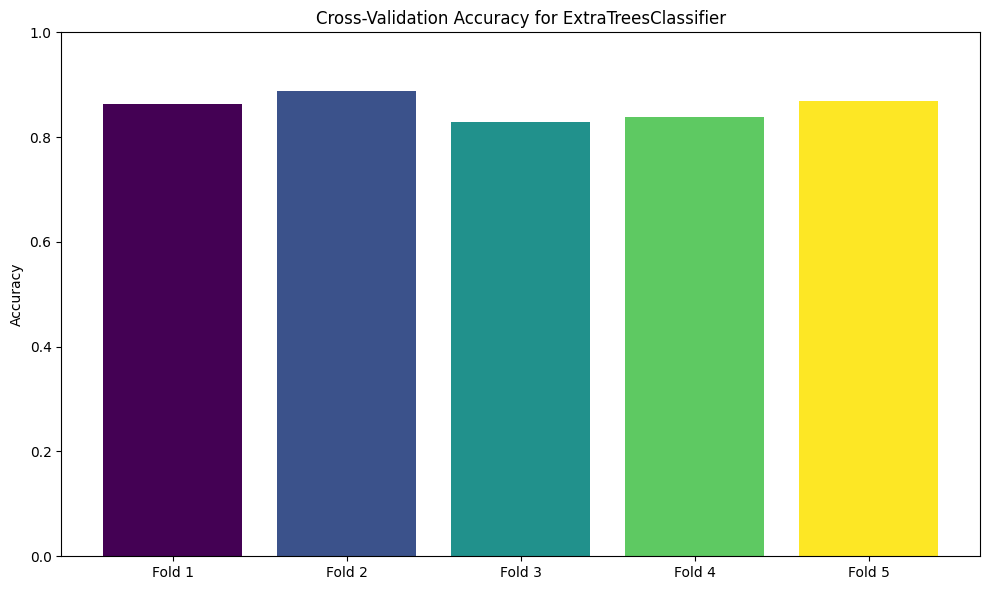

In [32]:
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(scores)))
plt.bar(range(len(scores)), scores, color=colors)
plt.xticks(range(len(scores)), [f"Fold {i+1}" for i in range(len(scores))])
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy for ExtraTreesClassifier')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [33]:
et.fit(x_train_pca, y_train)

ExtraTreesClassifier(n_estimators=300, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.83       201
           1       0.82      0.84      0.83       201

    accuracy                           0.83       402
   macro avg       0.83      0.83      0.83       402
weighted avg       0.83      0.83      0.83       402

Test Accuracy: 0.8283582089552238


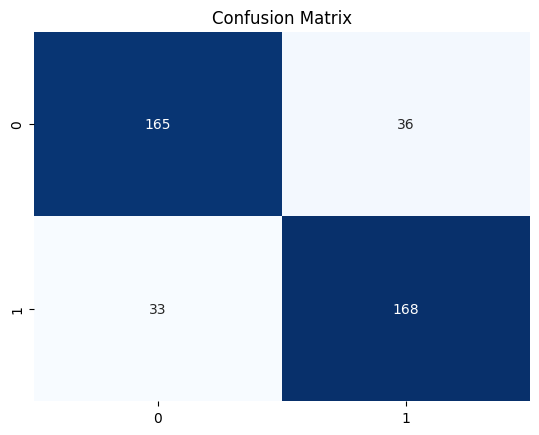

In [34]:
import seaborn as sns
# Evaluate the model on the test set
y_pred = et.predict(x_test_pca)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))


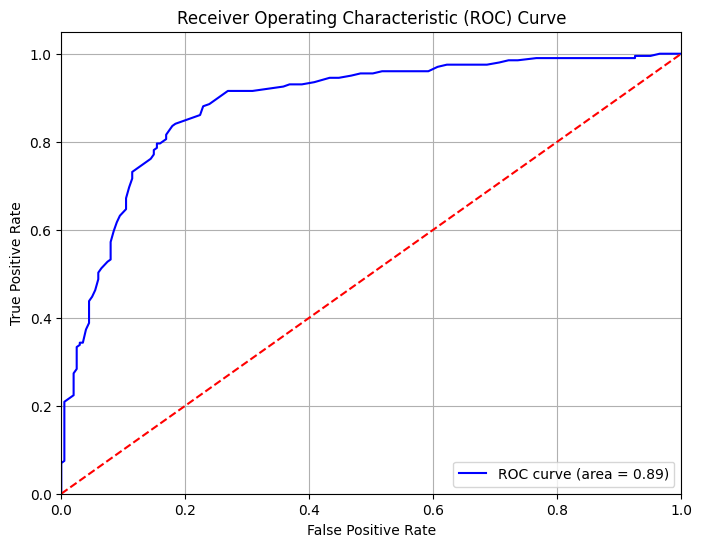

In [35]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, et.predict_proba(x_test_pca)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [36]:
# Save the model
import joblib
joblib.dump(et, 'ET_valence_model.pkl')



['ET_valence_model.pkl']